In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import skew

In [79]:
df = pd.DataFrame(pd.read_csv("./travelq.csv"))
df = df.dropna()
df.head()

,ref_number,disclosure_group,title_en,title_fr,name,purpose_en,purpose_fr,start_date,end_date,destination_en,...,airfare,other_transport,lodging,meals,other_expenses,total,additional_comments_en,additional_comments_fr,owner_org,owner_org_title
258,T-2019-P3-0001,SLE,Chairperson,Président,"Aterman, Paul",CCAT Symposium,Symposium du CTAC,2019-05-25,2019-05-28,Montreal (Quebec) Canada,...,0.00,241.96,464.10,153.20,-105.0,754.26,Negative amount in Other expenses is due to Mr...,Le montant négatif dans la colonne Autres dépe...,atssc-scdata,Administrative Tribunals Support Service of Ca...
265,T-2019-P3-0008,SLE,Chairperson,Président,"Brazeau, Ginette",Toronto - Cancelled trip \r\nThe hearing was r...,Toronto - Voyage annullé\r\nL'audience a été r...,2019-06-21,2019-06-21,Toronto (Ontario) Canada,...,560.07,0.00,0.00,0.00,113.0,673.07,Porter Credit available is $560.07 \r\nCancell...,"Crédit de 560,07$ de Porter est disponible\r\n...",atssc-scdata,Administrative Tribunals Support Service of Ca...
267,T-2019-P3-0010,SLE,Deputy Chief Administrator,Administrateur en chef adjoint,"Covelli, Nick",CCAT Symposium,Symposium du CTAC,2019-05-26,2019-05-28,Montreal (Quebec) Canada,...,0.00,231.33,817.53,223.95,0.0,1272.81,Mr. Covelli was replacing Mrs. Catherine Ebbs,M. Covelli remplaçait Mme Catherine Ebbs,atssc-scdata,Administrative Tribunals Support Service of Ca...
276,T-2019-P4-0001,SLE,Chairperson,Président,"Bélanger, Luc",Meeting for work,Rencontre de travail,2019-06-17,2019-06-21,"Halifax, N.S. & Quebec, Quebec, Canada",...,1190.90,671.69,917.06,451.50,0.0,3231.15,The flight from Montreal to Quebec City had te...,Le vol Montréal-Québec posait des problèmes te...,atssc-scdata,Administrative Tribunals Support Service of Ca...
279,T-2019-P4-0004,SLE,Chairperson,Président,"Brazeau, Ginette",Vancouver - Cancelled trip\r\nHearing being ca...,Vancouver - Voyage annulé\r\nAudience annulée ...,2019-07-29,2019-08-02,"Vancouver, Britsh Columbia, Canada",...,2989.79,0.00,0.00,0.00,0.0,2989.79,"Air Canada Credit available is $2,964.93\r\nHR...",Crédit de 2 964.93$ de Air Canada est disponib...,atssc-scdata,Administrative Tribunals Support Service of Ca...


In [80]:
#df = df[['TotalPop','Native','Hispanic','Asian','Pacific']]
#df = df[['Professional','Service','Office','Construction','Production']]
#df = df[['Drive','Carpool','Transit','Walk','OtherTransp']]
#df = df[['PrivateWork','PublicWork','SelfEmployed','FamilyWork']]

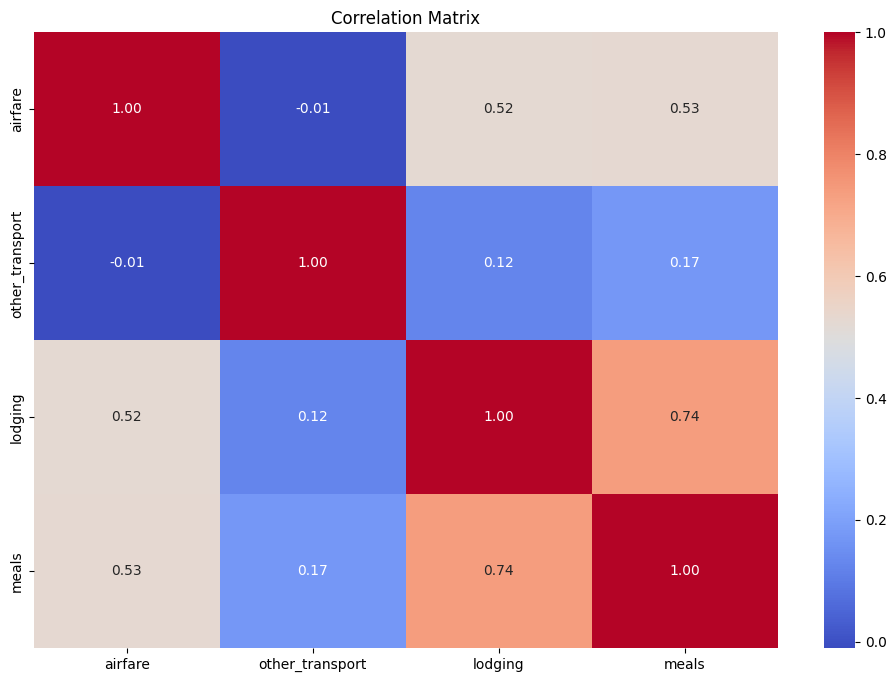

In [81]:
# Biểu đồ heatmap cho ma trận tương quan
plt.figure(figsize=(12, 8))
corr_matrix = df[['airfare','other_transport','lodging', 'meals']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [82]:
# Xác định các biến thành phần độc lập và biến giải thích
compositional_cols = ['airfare','other_transport','lodging', 'meals']
df = df[compositional_cols]
data = (df >= 0).all(axis=1)
df = df[data]
#data = 
var_target = df['airfare']
#family = family[(family != 0).all(axis=1)]
compositional_cols = ['other_transport','lodging','meals']
# chuyển dữ liệu thành phần
compositional_data = df[compositional_cols]
#compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()


,other_transport,lodging,meals
258,241.96,464.10,153.20
265,0.00,0.00,0.00
267,231.33,817.53,223.95
276,671.69,917.06,451.50
279,0.00,0.00,0.00


In [83]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = ilr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
#clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)
clr_compositional_data = pd.DataFrame(clr_compositional_data)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(clr_compositional_data, var_target, test_size=0.2, random_state=42)


# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                airfare   No. Observations:                 4043
Model:                            RLM   Df Residuals:                     4040
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 25 Jun 2024                                         
Time:                        10:56:10                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        788.7199     12.309     64.077      0.0

In [84]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 2160.91255851246


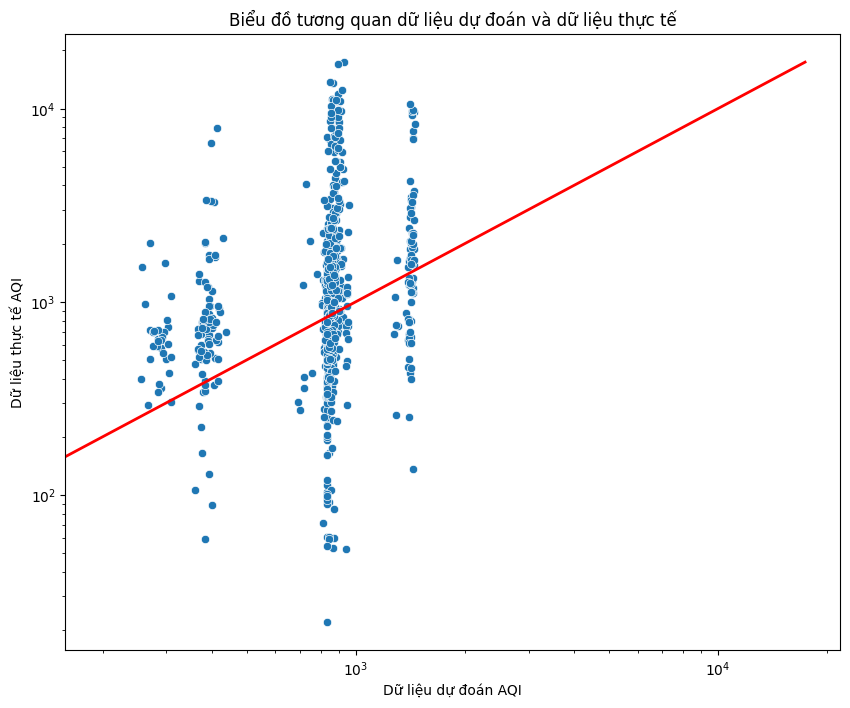

In [85]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dữ liệu dự đoán AQI')
plt.ylabel('Dữ liệu thực tế AQI')
plt.title('Biểu đồ tương quan dữ liệu dự đoán và dữ liệu thực tế')
plt.show()